In [27]:
import dask.dataframe as dd
from glob import glob
import numpy as np
import xarray as xr
import rasterio
import dask_image.imread
import imageio
import geopandas as gpd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
roi = 'ikh-nart'
#roi = 'rio-mora'

#dask call on gcsfs
#import gcsfs
#project_id = 'denver-zoo-fcps'
#token_file = './authentication/credentials.json'
#remotefile = f'gs://{roi}/tif_output/landsat_1986.tif'
#fs = gcsfs.GCSFileSystem(project=project_id, token=token_file)
##tif_files = [f for f in fs.ls(f'{roi}/tif_output') if '.tif' in f]

f = sorted(glob(f'/datadrive/{roi.replace("-","")}/tif/*.tif'))

In [3]:
raster = f[0]
ref = rasterio.open(raster)
x,y = ref.block_shapes[0]
img = xr.open_rasterio(raster, chunks={'band':1, 'x':x, 'y':y})
year = f[0].split('_')[1].split('.')[0]

In [ ]:
# now need to generate a time series of images aggregated to the season level.
# DJF MAM JJA SON

In [4]:
shp = glob('./data/shp/*/IN_boundary.shp')
shps = [gpd.read_file(fs) for fs in shp]
shp = gpd.read_file(shp[0])
minx, miny, maxx, maxy = shp.geometry.bounds.values[0]

In [ ]:
for j,raster in enumerate(f):
    year = raster.split('_')[1].split('.')[0]
    ref = rasterio.open(raster)
    x,y = ref.block_shapes[0]
    img = xr.open_rasterio(raster, chunks={'band':1, 'x':x, 'y':y})
    for month in range(1,13):
        selection = [f'B1_{month}', f'B3_{month}', f'B4_{month}']
        # we want to select band 2,3,4
        if month == 1:
            match = [(i+1,b) for i,b in enumerate(img.descriptions)\
                 if any(s == b for s in selection)]
        else:
            match = [(i+1,b) for i,b in enumerate(img.descriptions)\
                     if any(s in b for s in selection)]
        if match:
            match_index = [i[0] for i in match][:3]
            b1 = img.sel(band=match_index[0])
            b3 = img.sel(band=match_index[1])
            b4 = img.sel(band=match_index[2])
            #evi = 2.5 * ((b4 - b3) / (b4 + 6 * b3 - 7.5 * b1 +1))
            ndvi = ((b4-b3)/(b4+b3))
            annual_ndvi = ndvi.squeeze().compute().data
            if any(np.isnan(annual_ndvi.flatten())): #filter for empty sections of landsat
                continue
            else:
                fig, ax = plt.subplots(1,1,figsize=(6,8))
                ax.imshow(annual_ndvi, vmin=0, vmax=0.35, \
                                    extent=[minx,maxx, miny,maxy])
                ax.set_aspect('auto')
                ax.axis('off')
                #for s in shps[:1]:
                shp.plot(ax=ax, facecolor='none', \
                       edgecolor='red', lw=1)
                #ax.axis('equal')
                #ax[month-1].set_ylim([miny,maxy])
                #ax[i,month-1].title.set_text(f'{month}')
                fig.savefig(f'./figs/plots/ndvi_{year}%02d.png'%month,\
                            dpi=100, bbox_width='tight',pad_inches=0)
                plt.close()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  


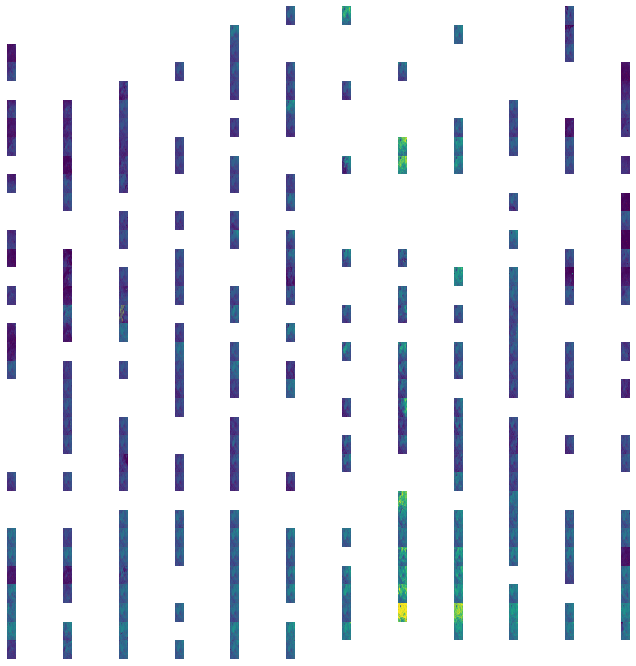

In [152]:
#now repeat for seasonal aggregate.
imgs = sorted(glob(f'./figs/plots/*'))
years = np.arange(1986,2021)
f, ax = plt.subplots(len(years), 12, figsize=(12,12))
plt.subplots_adjust(wspace=0, hspace=0)
f.tight_layout()
for row, y in enumerate(years):
    im = sorted([i for i in imgs if str(y) in i])
    months = [int(j.split('.')[1][-2:]) for j in im]
    outmonths = np.arange(1,13)
    outmonths = outmonths[~np.isin(outmonths,months)]
    for m in outmonths:
        ax[row,m-1].set_visible(False)
    for col,imfile in zip(months,im):
        image = np.array(Image.open(imfile))[290:-300,530:-480,:]
        ax[row,col-1].imshow(image)
        ax[row,col-1].axis('off')   
     

In [ ]:
#best thing to do is to write out the image for each month and each year
#then think about a seasonal level aggregate and write the image there too